In [1]:

import numpy as np
import matplotlib.pyplot as plt

def plot_1d_intervals_comparison(
    X_test,
    uncal_interval,                  # (n_lower, n_upper)
    cp_intervals,                    # (cp_lower, cp_upper)
    true_solution,                   # array OR callable f(X_test)
    uncal_interval_label="Before CP",
    cal_interval_label="After CP",
    t_train=None,
    y_train=None,
    title="PINN Prediction with Conformal & Naïve Intervals",
    figsize=(6, 5),
    colors=None,                     # optional dict to override colors by key
    alpha_cp=0.7,
    alpha_naive=1.0,
    dot_size=12,
    dot_edge_size=0.7,

):
    """
    Matches the styling/semantics of the plotting script:
      - CP-band mean is drawn as dashed prediction line
      - Legend at lower center with compact handles
      - Labeling uses x / u(x), fontsize=14, ylabel rotation=0
      - Same color palette and scatter edge styling
    """

    # --- default palette (same constants as your script) ---
    palette = {
        "COL_CP":   "#f7c5c8",
        "COL_MEAN": "#b13c32",
        "COL_NAIV": "#a3c3ea",
        "COL_TRUE": "#222222",
        "COL_SCAT": "#f6d09f",
        "COL_EDGE": "#222222",
    }
    if colors:
        palette.update(colors)
    COL_NAIV = palette["COL_NAIV"]
    COL_MEAN = palette["COL_MEAN"]
    COL_CP   = palette["COL_CP"]
    COL_TRUE = palette["COL_TRUE"]
    COL_SCAT = palette["COL_SCAT"]
    COL_EDGE = palette["COL_EDGE"]

    # --- evaluate truth if callable ---
    if callable(true_solution):
        true_vals = np.asarray(true_solution(X_test)).ravel()
    else:
        true_vals = np.asarray(true_solution).ravel()

    # --- to 1D arrays ---
    x = np.asarray(X_test).ravel()
    n_lower, n_upper = [np.asarray(a).ravel() for a in uncal_interval]
    cp_lower, cp_upper = [np.asarray(a).ravel() for a in cp_intervals]

    # CP mean (to match your script)
    pred_mean = (cp_lower + cp_upper) / 2.0

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # wide -> narrow bands first for nicer layering
    ax.fill_between(x, n_lower, n_upper, color=COL_NAIV, alpha=alpha_naive,
                    label=uncal_interval_label, zorder=1)
    ax.fill_between(x, cp_lower, cp_upper, color=COL_CP, alpha=alpha_cp,
                    label=cal_interval_label, zorder=2)

    # mean + truth
    ax.plot(x, pred_mean, ls="--", lw=2.0, color=COL_MEAN,
            label=r"Prediction", zorder=4)
    ax.plot(x, true_vals, lw=2.4, color=COL_TRUE,
            label=r"True", zorder=3)

    # training data (optional)
    if t_train is not None and y_train is not None:
        ax.scatter(np.asarray(t_train).ravel(), np.asarray(y_train).ravel(),
                   s=dot_size, facecolor=COL_SCAT, edgecolors=COL_EDGE,
                   linewidth=dot_edge_size, label="Data", zorder=5)

    # labels to match script
    ax.set_xlabel(r"$x$", fontsize=13)
    ax.set_ylabel(r"$u$", fontsize=13, rotation=90)

    # layout/styling to match script
    ax.margins(x=0)
    ax.legend(loc="upper right", handlelength=1.6, borderpad=0.6)
    fig.tight_layout()

    return fig, ax


# Data

Using device: cpu
Using device: cpu


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


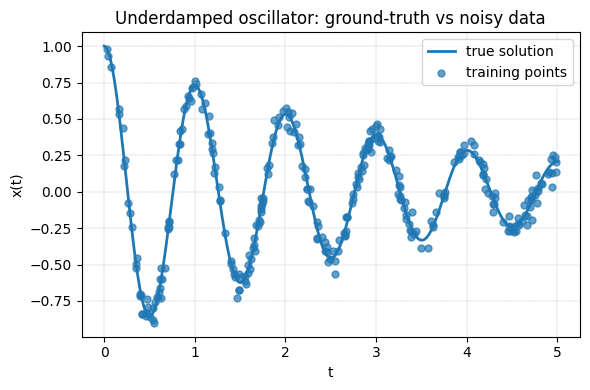

In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from utils_tools.utils_tuning import save_plot

torch.set_num_threads(4)
seed = 95
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_damposcillation import DampedOscillator1D  

ζ      = 0.05                       # damping ratio
ω      = 2 * math.pi * 1.0          # natural frequency (1 Hz)
ω_d    = ω * math.sqrt(1 - ζ**2)    # damped natural frequency
u0, v0 = 1.0, 0.0                   # initial displacement & velocity

forcing_func  = lambda t: 0.0 * t   # zero external force

true_solution = lambda t: (
    np.exp(-ζ * ω * t) *
    (u0 * np.cos(ω_d * t) + (v0 + ζ * ω * u0) / ω_d * np.sin(ω_d * t))
)

domain = (0.0, 5.0)                 # simulate 10 s

pde = DampedOscillator1D(
    zeta=ζ, omega=ω, forcing_func=forcing_func,
    init_cond=(u0, v0), domain=domain, true_solution=true_solution
)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Training / calibration / test data
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 200

data_noise = 0.05
(X_train, Y_train)         = pde.data_generation(300, data_noise)
(X_test, Y_test)           = pde.data_generation(1000, data_noise)


# Not involved in numerical experiment
(X_calibration, Y_calibration) = pde.data_generation(150, data_noise)
# Dense grid for nice plotting or other stuff, unrelated to the numerical experiment 
(X_vis, Y_vis) = pde.data_generation(400, data_noise)



# Collocation points in (0,5)
x_collocation = torch.linspace(*domain, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > domain[0]) & (x_collocation < domain[1])].view(-1, 1)
grid_test = torch.linspace(*domain, 3000).unsqueeze(1)

# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

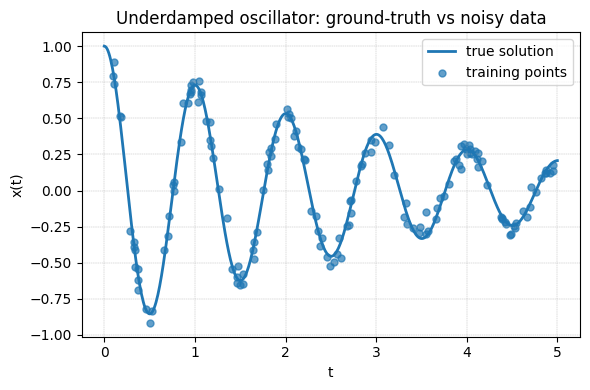

In [3]:
plot_truth_and_samples_1D(
    *domain,
    X_train   = X_calibration,
    Y_train   = Y_calibration,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

In [4]:
import torch

def add_heteroscedastic_noise_islands(
    X, Y_clean,
    *,
    centers=(1, 2, 3),
    widths=(0.2, 0.2, 0.2),
    bump=0.3,
    baseline=0.0,
    seed=None,
    return_sigma=False,
    return_indices=True
):
    """
    Add heteroscedastic Gaussian noise in local 'islands' (zero outside [c-w, c+w]).

    Returns (depending on flags, in this exact order):
        noisy_idx (LongTensor, 1D)  if return_indices=True
        Y_noisy   (Tensor, like Y_clean)
        sigma     (Tensor, like X)  if return_sigma=True
    """
    assert X.ndim == 2 and X.shape[1] == 1, "X must be (N,1)"
    assert X.device == Y_clean.device, "X and Y_clean must be on the same device"
    device = X.device

    x = X
    sigma = torch.full_like(x, fill_value=baseline)
    inside_mask = torch.zeros_like(x, dtype=torch.bool)

    for c, w in zip(centers, widths):
        phi = torch.exp(-0.5 * ((x - c) / (w + 1e-12))**2)
        box = (x >= c - w) & (x <= c + w)     # hard cutoff
        phi = phi * box
        sigma = sigma + bump * phi
        inside_mask |= box

    if seed is not None:
        torch.manual_seed(int(seed))

    z = torch.randn_like(Y_clean)
    Y_noisy = Y_clean + sigma * z

    if return_indices:
        noisy_idx = torch.nonzero(inside_mask.squeeze(-1), as_tuple=True)[0].to(device=device, dtype=torch.long)

    if return_sigma and return_indices:
        return noisy_idx, Y_noisy, sigma
    elif return_sigma:
        return Y_noisy, sigma
    elif return_indices:
        return noisy_idx, Y_noisy
    else:
        return Y_noisy


In [5]:
# True outputs without noise
Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()
Y_vis_clean   = Y_vis.clone()

# Add heteroscedastic noise
id_train, Y_train        = add_heteroscedastic_noise_islands(X_train, Y_train_clean)
id_test, Y_test         = add_heteroscedastic_noise_islands(X_test,  Y_test_clean)
id_calibration, Y_calibration  = add_heteroscedastic_noise_islands(X_calibration, Y_cal_clean)
id_vis, Y_vis  = add_heteroscedastic_noise_islands(X_vis, Y_vis_clean)


In [6]:
# Visualize the graph
from utils_tools.utils_result_viz import plot_truth_and_samples_1D
save_plot(
    plot_truth_and_samples_1D,
    save_dir="Adaptive_scaled_CP",
    prefix="heteroscedasticity_data"
)(
    *domain,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=true_solution,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

<Figure size 640x480 with 0 Axes>

# Training Base Model

In [7]:
# UQ Model
from utils_uqmd.utils_uq_distance import DistanceUQPINN

model_args = {
    "pde_class":pde,
    "input_dim":1,
    "hidden_dims":[16, 32, 64, 128, 128, 64, 32, 16],
    "output_dim":1,
}

uqmodel = DistanceUQPINN(**model_args)

alpha = 0.1
k=30

raw_heuristic = "feature"

# Fit the data
fit_args = dict(coloc_pt_num=200, X_train=X_train, Y_train=Y_train)
fit_kwargs_grid = dict(
    epochs=20000,
    λ_pde= 1.0, λ_ic=10.0, λ_data=3.0,
    lr=1e-3, stop_schedule=40000
)
print(f"\n[🟠] Training...")
baseline_loss_dict = uqmodel.fit(**fit_args, **fit_kwargs_grid)




[🟠] Training...
ep     1 | L=4.04e+03 | lr=1.0e-03
ep   500 | L=6.22e+00 | lr=1.0e-03
ep  1000 | L=4.40e+00 | lr=1.0e-03
ep  1500 | L=2.92e+00 | lr=1.0e-03
ep  2000 | L=1.77e+00 | lr=1.0e-03
ep  2500 | L=1.45e+00 | lr=1.0e-03
ep  3000 | L=1.17e+00 | lr=1.0e-03
ep  3500 | L=9.81e-01 | lr=1.0e-03
ep  4000 | L=6.15e-01 | lr=1.0e-03
ep  4500 | L=4.55e-01 | lr=1.0e-03
ep  5000 | L=1.51e-01 | lr=1.0e-03
ep  5500 | L=1.28e-01 | lr=7.0e-04
ep  6000 | L=1.18e-01 | lr=7.0e-04
ep  6500 | L=3.14e-01 | lr=7.0e-04
ep  7000 | L=6.91e-02 | lr=7.0e-04
ep  7500 | L=6.19e-02 | lr=7.0e-04
ep  8000 | L=2.32e-01 | lr=7.0e-04
ep  8500 | L=2.50e-01 | lr=7.0e-04
ep  9000 | L=1.11e-01 | lr=7.0e-04
ep  9500 | L=9.83e-02 | lr=7.0e-04
ep 10000 | L=1.02e-01 | lr=7.0e-04
ep 10500 | L=6.22e-02 | lr=4.9e-04
ep 11000 | L=1.01e-01 | lr=4.9e-04
ep 11500 | L=1.09e-01 | lr=4.9e-04
ep 12000 | L=8.18e-02 | lr=4.9e-04
ep 12500 | L=8.20e-02 | lr=4.9e-04
ep 13000 | L=1.18e-01 | lr=4.9e-04
ep 13500 | L=7.01e-02 | lr=4.9e-04
ep 

In [8]:
# Model Inferencing
baseline_pred_kwargs = dict(n_samples=40, heuristic_u=raw_heuristic)
print(f"\n[🟠] Base Model Inferencing...")
cp_uncal_predset = uqmodel.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


[🟠] Base Model Inferencing...


# Adaptive Scaled CP

In [9]:
 # CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP, adaptive_cp_test_uncertainties_grid
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 128, 128, 64, 32, 16),
    "conf_nn_lr":1e-4,
    "conf_nn_epochs":15000
}
adap_cp = AdaptiveCP(uqmodel, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


In [10]:

save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=adp_cp_cal_predset,
    uncal_interval_label="Naive UQ Band",
    cal_interval_label="Adaptive Scaled CP Band",
    true_solution=pde.true_solution,            # pass the function
    t_train=X_vis,
    y_train=Y_vis,
    title="0.05-Alpha Level Adaptive Scaled Conformal Calibrated Prediction"
)

<Figure size 640x480 with 0 Axes>

# Normal Scaled CP

In [11]:
# Normal CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":raw_heuristic,  # Change this based on cp
        "k":k
}
from utils_uqmd.utils_uq_cp import CP
cp_model = CP(uqmodel)
cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=grid_test,
            **cp_pred_kwargs
            )

In [12]:
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="cp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_uncal_predset,
    cp_intervals=cp_cal_predset,
    true_solution=pde.true_solution, 
    uncal_interval_label="Naive UQ Band",
    cal_interval_label="Scaled CP Band",
    t_train=X_vis,
    y_train=Y_vis,
    title="0.05-Alpha Level Scaled Conformal Calibrated Prediction"
)

<Figure size 640x480 with 0 Axes>

# Visual Comparison: Scaled CP v.s. Adaptive Scaled CP

In [13]:
id_vis, Y_test, sigma_test = add_heteroscedastic_noise_islands(X_test, Y_test, return_sigma=True)

import torch, numpy as np

def as_long_idx(idx, device):
    if isinstance(idx, np.ndarray):
        return torch.as_tensor(idx, dtype=torch.long, device=device)
    elif not torch.is_tensor(idx):
        return torch.as_tensor(idx, dtype=torch.long, device=device)
    else:
        return idx.to(device=device, dtype=torch.long)

idx = as_long_idx(id_test, X_test.device)

# 1a) in-range, 1-D, non-empty
assert idx.ndim == 1 and idx.numel() > 0, "[idx] empty or not 1-D"
assert (0 <= idx.min()) and (idx.max() < X_test.shape[0]), "[idx] out of range"

# 1b) duplicates?
num_dup = idx.numel() - torch.unique(idx).numel()
print(f"[idx] duplicates = {num_dup}")

# 1c) monotone (only for info; non-monotone is OK)
inversions = int((torch.diff(X_test[idx].view(-1)) < 0).sum().item())
print(f"[idx] inversions (non-monotone count) = {inversions}")


[idx] duplicates = 0
[idx] inversions (non-monotone count) = 118


(<Figure size 600x500 with 1 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

<Figure size 640x480 with 0 Axes>

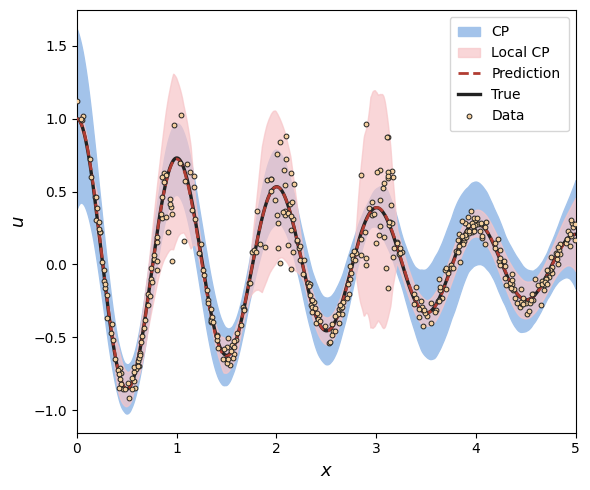

In [14]:
save_plot(
    plot_1d_intervals_comparison,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_predset"
)(
    X_test=grid_test,
    uncal_interval=cp_cal_predset,
    cp_intervals=adp_cp_cal_predset,
    true_solution=pde.true_solution,            
    uncal_interval_label="CP",
    cal_interval_label="Local CP",
    t_train=X_vis,
    y_train=Y_vis,
)

plot_1d_intervals_comparison(
    X_test=grid_test,
    uncal_interval=cp_cal_predset,
    cp_intervals=adp_cp_cal_predset,
    true_solution=pde.true_solution,            
    uncal_interval_label="CP",
    cal_interval_label="Local CP",
    t_train=X_vis,
    y_train=Y_vis,
)


# Bar Plot

In [15]:
from utils_tools.utils_extension_vis_1d import local_noise_max_from_xy, plot_local_error_grid_2x2

X_bar, Y_bar = pde.data_generation_uniform(3000)
Y_bar_clean = Y_bar.clone()
id_bar, Y_bar   = add_heteroscedastic_noise_islands(X_bar,  Y_bar_clean, baseline=0.05)
true_err, _, _ = local_noise_max_from_xy(X_bar, Y_bar, k=5, metric="mae")

In [16]:
cp_uncal_predset = uqmodel.predict(alpha, X_bar, 
                                   **baseline_pred_kwargs)

cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=X_bar,
            **cp_pred_kwargs
            )

adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=X_bar, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)

In [17]:
# X, Y are torch tensors

# true_err= theoretical_noise_uniform(
#     3000, (0.0, 5.0)
# )
heu_width = (cp_uncal_predset[1]- cp_uncal_predset[0])/2
cp_width = (cp_cal_predset[1]- cp_cal_predset[0])/2
adap_width = (adp_cp_cal_predset[1]- adp_cp_cal_predset[0])/2

(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: ylabel='Error'>, <Axes: >,
        <Axes: xlabel='$x$', ylabel='Error'>, <Axes: xlabel='$x$'>],
       dtype=object))

<Figure size 640x480 with 0 Axes>

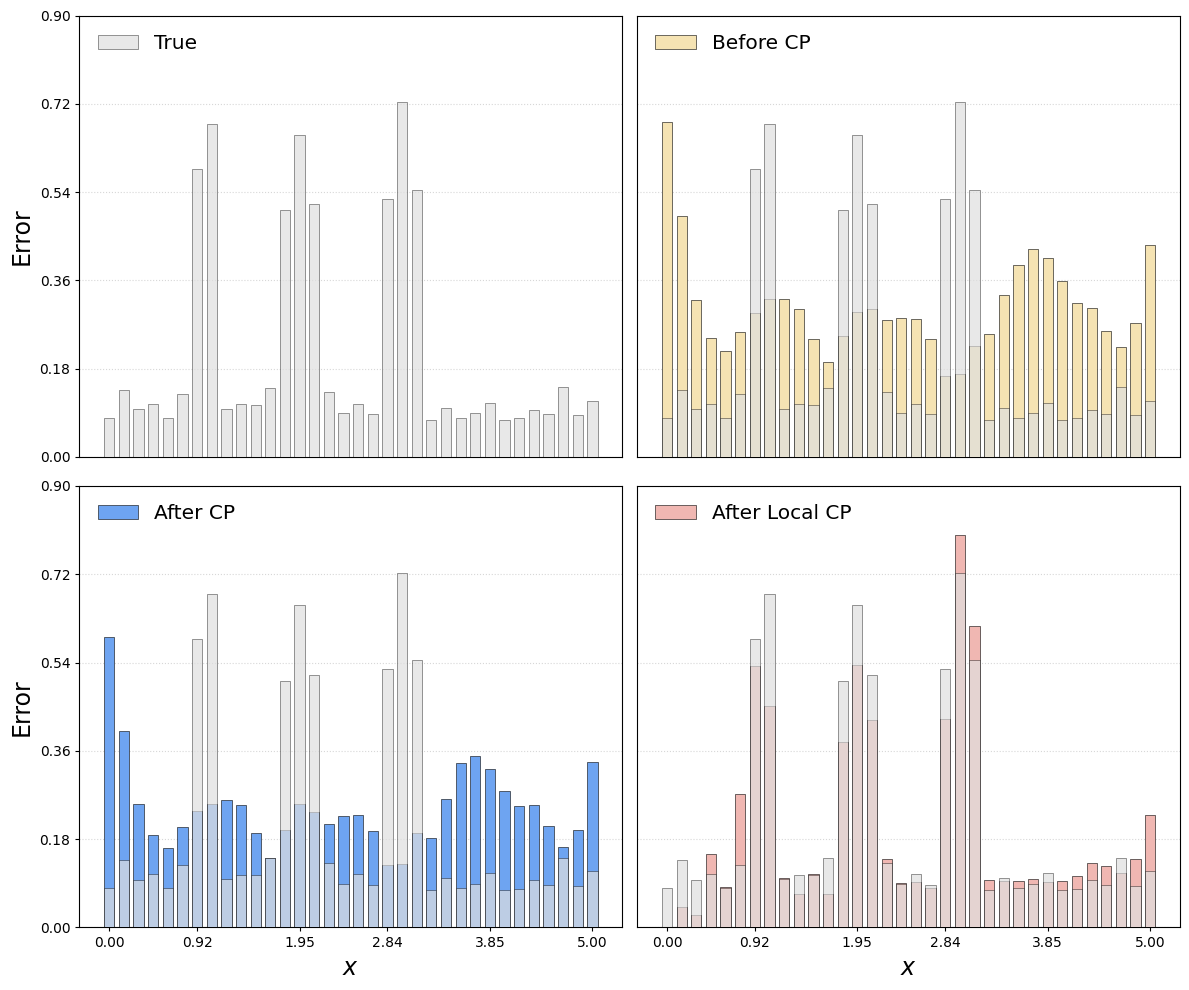

In [18]:
nbar = 34
from utils_tools.utils_extension_vis_1d import plot_local_error_grid_2x2
save_plot(
    plot_local_error_grid_2x2,
    save_dir="Adaptive_scaled_CP",
    prefix="bar_plots"
)(
    X_test=X_bar,
    true_err=true_err,
    heu_width=heu_width, 
    cp_width=cp_width,
    adap_width=adap_width,
    sharey=True,   # optional same y-scale
    ylims = ((0, 0.9),(0, 0.9),(0, 0.9),(0, 0.9)),
    nbar=(nbar,nbar,nbar,nbar)
)

plot_local_error_grid_2x2(
    X_test=X_bar,
    true_err=true_err,
    heu_width=heu_width, 
    cp_width=cp_width,
    adap_width=adap_width,
    sharey=True,   # optional same y-scale
    ylims = ((0, 0.9),(0, 0.9),(0, 0.9),(0, 0.9)),
    nbar=(nbar,nbar,nbar,nbar)
)


# Test Model Local Coverage

In [19]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)


cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:34<10:25, 34.76s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:09<09:48, 34.61s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:43<09:09, 34.32s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:15<08:21, 33.44s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [02:48<07:47, 33.37s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:21<07:12, 33.23s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [03:54<06:35, 32.99s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [04:26<06:01, 32.85s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [04:59<05:29, 32.93s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [05:32<04:56, 32.94s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [06:05<04:23, 32.90s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [06:39<03:51, 33.13s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [07:12<03:18, 33.13s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [07:45<02:46, 33.31s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [08:21<02:15, 33.83s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [08:55<01:42, 34.08s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [09:28<01:07, 33.79s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [10:02<00:33, 33.91s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [10:36<00:00, 33.52s/it]


In [20]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
import pandas as pd
def plot_dual_expected_vs_empirical(
    df_uncal,
    df_cal,
    *,
    alpha_col="alpha",
    cov_col="coverage",
    title1="Uncalibrated Model",
    title2="Calibrated Model",
    dev_metric="mae",
    main_title="Coverage: Uncalibrated vs Calibrated",
    figsize=(12, 6),
    constrained=True,           # set False if you prefer tight_layout()
    title_pad=14,               # vertical offset for the figure title
    tight_rect=(0, 0, 1, 0.96), # head-room if constrained=False
):
    """
    Side-by-side coverage plots for uncalibrated and calibrated models.

    The subtitle of each panel shows the deviation from ideal calibration
    (MAE / RMSE / max absolute error).

    Parameters
    ----------
    df_uncal, df_cal : pd.DataFrame
        Must contain columns `alpha_col` and `cov_col`.
    dev_metric : {"mae", "rmse", "max"}
        Metric used for the deviation shown under each panel title.
    main_title : str or None
        Figure-level title.  Set None to suppress it.
    constrained : bool
        Use Matplotlib’s constrained-layout engine (recommended).
        If False, the function falls back to tight_layout with `tight_rect`.
    """

    # ------------------------------------------------------------------
    # helpers
    def _prepare(df):
        exp = 1.0 - df[alpha_col]
        emp = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), exp, pd.Series([1.0])],
                             ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), emp, pd.Series([1.0])],
                             ignore_index=True)
        order = exp_full.argsort()
        return exp_full[order].to_numpy(), emp_full[order].to_numpy()

    def _deviation(e, m, how):
        diff = np.abs(m - e)
        if how == "mae":
            return diff.mean()
        if how == "rmse":
            return np.sqrt((diff ** 2).mean())
        if how == "max":
            return diff.max()
        raise ValueError("dev_metric must be 'mae', 'rmse', or 'max'")

    # ------------------------------------------------------------------
    # data + metrics
    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)
    dev1 = _deviation(exp1, emp1, dev_metric)
    dev2 = _deviation(exp2, emp2, dev_metric)

    # ------------------------------------------------------------------
    # figure & axes
    if constrained:
        fig, axes = plt.subplots(1, 2, figsize=figsize,
                                 constrained_layout=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)

    # panel 1 – uncalibrated
    axes[0].plot(exp1, emp1, marker="o", label="Empirical")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[0].set_title(f"{title1}\nDeviation ({dev_metric.upper()}): {dev1:.3f}")
    axes[0].set_xlabel("Expected Coverage  (1 − α)")
    axes[0].set_ylabel("Empirical Coverage")
    axes[0].grid(True)
    axes[0].legend()

    # panel 2 – calibrated
    axes[1].plot(exp2, emp2, marker="o", label="Empirical")
    axes[1].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[1].set_title(f"{title2}\nDeviation ({dev_metric.upper()}): {dev2:.3f}")
    axes[1].set_xlabel("Expected Coverage  (1 − α)")
    axes[1].set_ylabel("Empirical Coverage")
    axes[1].grid(True)
    axes[1].legend()

    # ------------------------------------------------------------------
    # figure-level title and layout finish
    if main_title:
        fig.suptitle(main_title, y=1.1, fontsize=12)

    if not constrained:            # tidy up only if we skipped the CL engine
        fig.tight_layout(rect=tight_rect)

    return fig, axes

save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_cp_coverage_plot_LOCAL"
)(cp_df_local, adap_df_local, title1="Scaled CP", title2="Adaptive Scaled CP", 
  main_title="Coverage Plot of Adaptive Conformal Prediction & Conformal Prediction Across Alpha Levels")

<Figure size 640x480 with 0 Axes>

Uncal dev:0.29253199598973706
Cal dev:0.06687644141770545
Uncal dev:0.29253199598973706
Cal dev:0.06687644141770545


<Figure size 640x480 with 0 Axes>

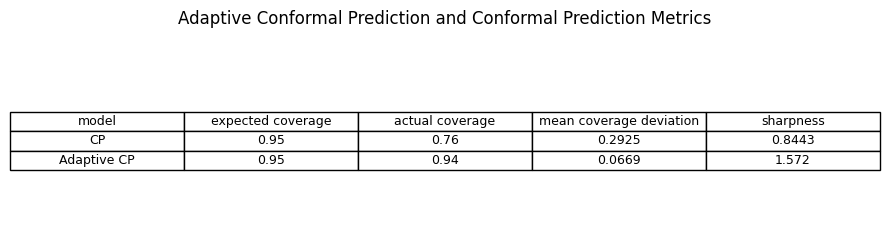

In [21]:
from utils_tools.utils_result_viz import plot_metrics_table

df1=cp_df_local
df2=adap_df_local
df1_name="CP" 
df2_name="Adaptive CP"
save_plot(
    plot_metrics_table,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_table_LOCAL"
)(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")



plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics"
)


# Test model's Global coverage

In [22]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)


cp_testing_args = {
    "uqmodel": cp_model,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
adapcp_testing_args = {
    "base_md": uqmodel,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":20
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:36<10:48, 36.01s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [01:10<09:54, 34.98s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [01:42<09:01, 33.84s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [02:14<08:16, 33.10s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [02:46<07:39, 32.79s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [03:18<07:02, 32.53s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [03:50<06:26, 32.20s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [04:21<05:51, 31.94s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [04:53<05:18, 31.86s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [05:25<04:47, 31.96s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [05:57<04:15, 31.95s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [06:29<03:42, 31.77s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [07:01<03:11, 31.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [07:32<02:38, 31.78s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [08:04<02:07, 31.89s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [08:36<01:35, 31.69s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [09:07<01:03, 31.61s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [09:39<00:31, 31.55s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [10:10<00:00, 32.15s/it]


In [23]:
from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
import pandas as pd
def plot_dual_expected_vs_empirical(
    df_uncal,
    df_cal,
    *,
    alpha_col="alpha",
    cov_col="coverage",
    title1="Uncalibrated Model",
    title2="Calibrated Model",
    dev_metric="mae",
    main_title="Coverage: Uncalibrated vs Calibrated",
    figsize=(12, 6),
    constrained=True,           # set False if you prefer tight_layout()
    title_pad=14,               # vertical offset for the figure title
    tight_rect=(0, 0, 1, 0.96), # head-room if constrained=False
):
    """
    Side-by-side coverage plots for uncalibrated and calibrated models.

    The subtitle of each panel shows the deviation from ideal calibration
    (MAE / RMSE / max absolute error).

    Parameters
    ----------
    df_uncal, df_cal : pd.DataFrame
        Must contain columns `alpha_col` and `cov_col`.
    dev_metric : {"mae", "rmse", "max"}
        Metric used for the deviation shown under each panel title.
    main_title : str or None
        Figure-level title.  Set None to suppress it.
    constrained : bool
        Use Matplotlib’s constrained-layout engine (recommended).
        If False, the function falls back to tight_layout with `tight_rect`.
    """

    # ------------------------------------------------------------------
    # helpers
    def _prepare(df):
        exp = 1.0 - df[alpha_col]
        emp = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), exp, pd.Series([1.0])],
                             ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), emp, pd.Series([1.0])],
                             ignore_index=True)
        order = exp_full.argsort()
        return exp_full[order].to_numpy(), emp_full[order].to_numpy()

    def _deviation(e, m, how):
        diff = np.abs(m - e)
        if how == "mae":
            return diff.mean()
        if how == "rmse":
            return np.sqrt((diff ** 2).mean())
        if how == "max":
            return diff.max()
        raise ValueError("dev_metric must be 'mae', 'rmse', or 'max'")

    # ------------------------------------------------------------------
    # data + metrics
    exp1, emp1 = _prepare(df_uncal)
    exp2, emp2 = _prepare(df_cal)
    dev1 = _deviation(exp1, emp1, dev_metric)
    dev2 = _deviation(exp2, emp2, dev_metric)

    # ------------------------------------------------------------------
    # figure & axes
    if constrained:
        fig, axes = plt.subplots(1, 2, figsize=figsize,
                                 constrained_layout=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)

    # panel 1 – uncalibrated
    axes[0].plot(exp1, emp1, marker="o", label="Empirical")
    axes[0].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[0].set_title(f"{title1}\nDeviation ({dev_metric.upper()}): {dev1:.3f}")
    axes[0].set_xlabel("Expected Coverage  (1 − α)")
    axes[0].set_ylabel("Empirical Coverage")
    axes[0].grid(True)
    axes[0].legend()

    # panel 2 – calibrated
    axes[1].plot(exp2, emp2, marker="o", label="Empirical")
    axes[1].plot([0, 1], [0, 1], "--", color="gray", label="Ideal  y=x")
    axes[1].set_title(f"{title2}\nDeviation ({dev_metric.upper()}): {dev2:.3f}")
    axes[1].set_xlabel("Expected Coverage  (1 − α)")
    axes[1].set_ylabel("Empirical Coverage")
    axes[1].grid(True)
    axes[1].legend()

    # ------------------------------------------------------------------
    # figure-level title and layout finish
    if main_title:
        fig.suptitle(main_title, y=1.1, fontsize=12)

    if not constrained:            # tidy up only if we skipped the CL engine
        fig.tight_layout(rect=tight_rect)

    return fig, axes

save_plot(
    plot_dual_expected_vs_empirical,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_cp_coverage_plot_GLOBAL"
)(cp_df_global, adap_df_global, title1="CP", title2="Adaptive CP", 
  main_title="Coverage Plot of Adaptive Conformal Prediction & Conformal Prediction Across Alpha Levels")

<Figure size 640x480 with 0 Axes>

Uncal dev:0.024999998687278657
Cal dev:0.018285710009790603
Uncal dev:0.024999998687278657
Cal dev:0.018285710009790603


<Figure size 640x480 with 0 Axes>

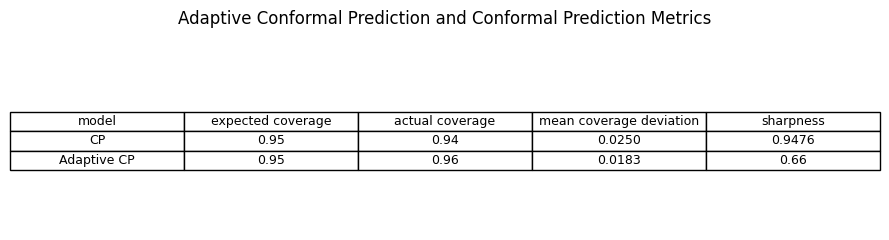

In [24]:
from utils_tools.utils_result_viz import plot_metrics_table

df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"
save_plot(
    plot_metrics_table,
    save_dir="Adaptive_scaled_CP",
    prefix="adpcp_vs_cp_table_GLOBAL"
)(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")


plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics"
)

In [25]:
def plot_coverage_grid_1x2_centered_legend(
    named_pairs,
    *,
    labels=("Local CP","CP"),
    grid_figsize=(17, 7.5),
    suptitle=None,
    model_title_size=22,
    middle_ratio=0.35,   # adjust space for legend between plots
    float_labels=(("Partial", r"$x \in [0.8, 1.2] \cup [1.8, 2.2] \cup [2.8, 3.2]}$"), ("Global", r"$x \in [0,5]$")),  # new floating labels
):
    """
    Plot 2 coverage plots side by side with the legend box
    placed directly in the middle between them. Each plot
    gets a floating text label at the upper-left corner.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)
    if len(items) != 2:
        raise ValueError("Provide exactly 2 (name, df_uncal, df_cal) pairs.")

    # 1x3 layout: [plot1 | legend | plot2]
    fig, axs = plt.subplots(
        1, 3,
        figsize=grid_figsize,
        sharey=True,
        gridspec_kw={"width_ratios": [1.0, middle_ratio, 1.0]}
    )

    legend_handles, legend_labels = None, None

    # Left and right plots
    for ax_plot, (name, df_uncal, df_cal), flabel in zip([axs[0], axs[2]], items, float_labels):
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)
        ax_plot.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
                     ms=16, lw=5, label=labels[1])
        ax_plot.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=22, lw=5, label=labels[0])
        
        ax_plot.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

        if legend_handles is None:
            legend_handles, legend_labels = ax_plot.get_legend_handles_labels()

        ax_plot.set_xlabel("Expected Coverage (1 − α)", fontsize=20)
        ax_plot.autoscale(enable=True, tight=False)
        ax_plot.margins(x=0.02, y=0.02)
        ax_plot.set_title(name, fontsize=model_title_size)
        ax_plot.tick_params(axis='both', labelsize=15)

        # floating label in upper-left corner
        ax_plot.text(
            0.02, 0.98, flabel[0],
            transform=ax_plot.transAxes,
            fontsize=25, 
            fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )
        ax_plot.text(
            0.02, 0.9, flabel[1],
            transform=ax_plot.transAxes,
            fontsize=20, 
            fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )
        

    axs[0].set_ylabel("Empirical Coverage", fontsize=20)

    # Middle subplot: legend only
    axs[1].axis("off")
    axs[1].legend(
        legend_handles, legend_labels,
        loc="lower center", frameon=True, fontsize=20, ncol=1
    )

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2, y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return fig, axs
    


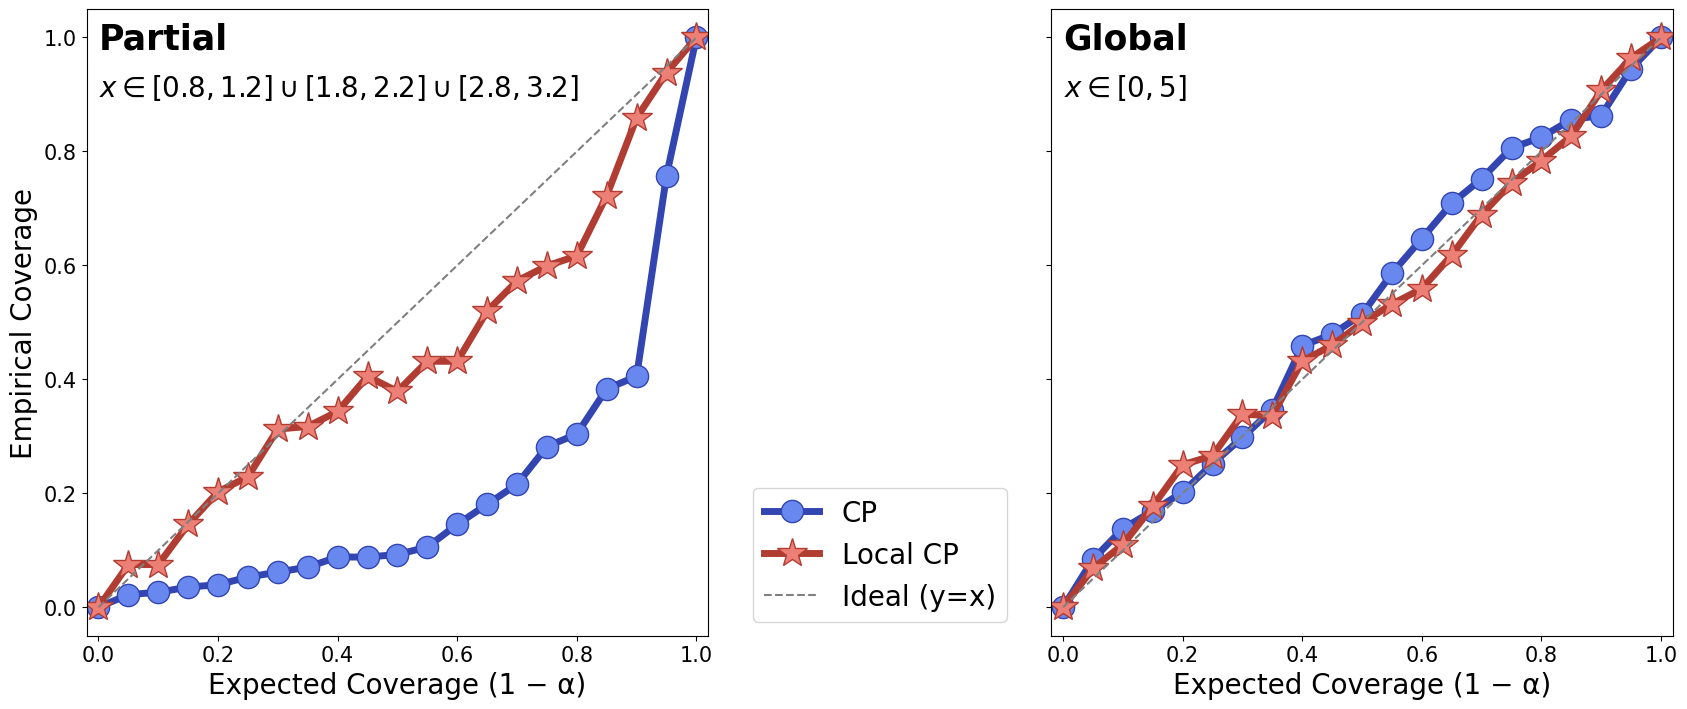

<Figure size 640x480 with 0 Axes>

In [26]:
pairs = [
    ("",    cp_df_local,  adap_df_local),
    ("", cp_df_global,    adap_df_global),
]
fig, axs = plot_coverage_grid_1x2_centered_legend(pairs)
save_plot(
    plot_coverage_grid_1x2_centered_legend,
    save_dir="Adaptive_scaled_CP",
    prefix="coverage_sets"
)(pairs)

In [27]:
# Compute mean
pred_set_plot = uqmodel.predict(alpha, X_test, 
                            **baseline_pred_kwargs)
pred_mean_plot = (pred_set_plot[0] + pred_set_plot[1])/2